In [1]:
# testing a simple BO setup plugging in a gpytorch approximate gp with
# pll variational inference for fitting - testing GIBBON acq


In [2]:
# imports
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from botorch import fit_gpytorch_mll
from botorch.models.gp_regression import SingleTaskGP
from botorch.models import SingleTaskVariationalGP
from botorch.fit import fit_gpytorch_mll_torch
from gpytorch.mlls import ExactMarginalLogLikelihood, PredictiveLogLikelihood, VariationalELBO
import numpy as np
from botorch.models.transforms import Normalize, Standardize

# setup
dtype = torch.double
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import warnings
from botorch.exceptions import BadInitialCandidatesWarning
warnings.filterwarnings('ignore', category=BadInitialCandidatesWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

In [7]:
# test function - mean
def example_mean_torch(x):
    x = x
    y = torch.zeros(x.shape)
    y += torch.cos(x * 2 * torch.pi)
    return -y + 1.0


<Axes: >

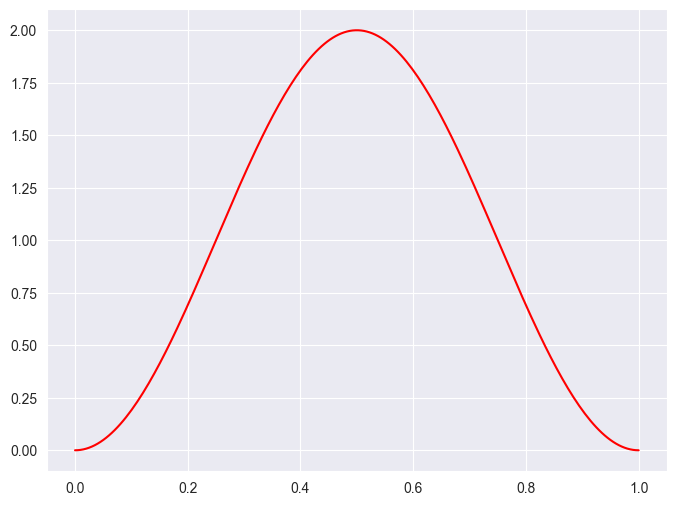

In [8]:
# plot the test function
x1 = torch.linspace(0,1.0,200)
y1 = example_mean_torch(x1)
fig, ax = plt.subplots(1, 1, figsize=(8,6))
sns.lineplot(x=x1, y=y1, ax=ax, color='r')

In [9]:
def example_noise_torch(x):
    x = x
    y = torch.zeros(x.shape)
    y += torch.randn(x.shape).mul(x.pow(3) * 1.)
    return y


<Axes: >

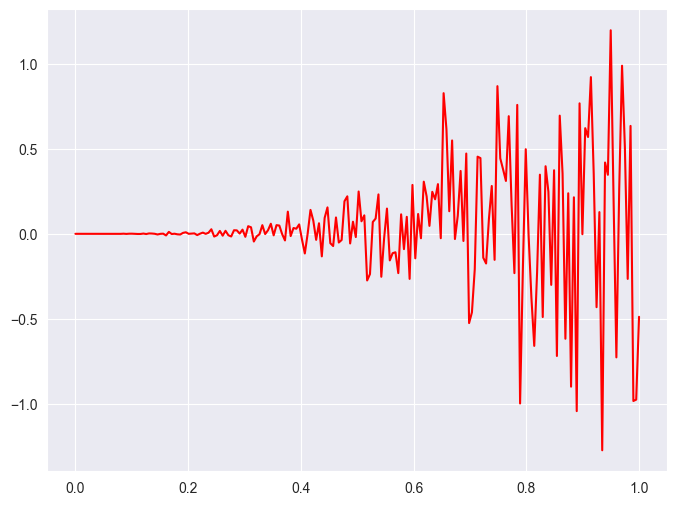

In [10]:
x1 = torch.linspace(0,1.0,200)
y1 = example_noise_torch(x1)
fig, ax = plt.subplots(1, 1, figsize=(8,6))
sns.lineplot(x=x1, y=y1, ax=ax, color='r')

In [11]:
# combined function
def combined_torch(x):
    x = x
    y = torch.zeros(x.shape)
    y += example_mean_torch(x)
    y += example_noise_torch(x)
    return y

<Axes: >

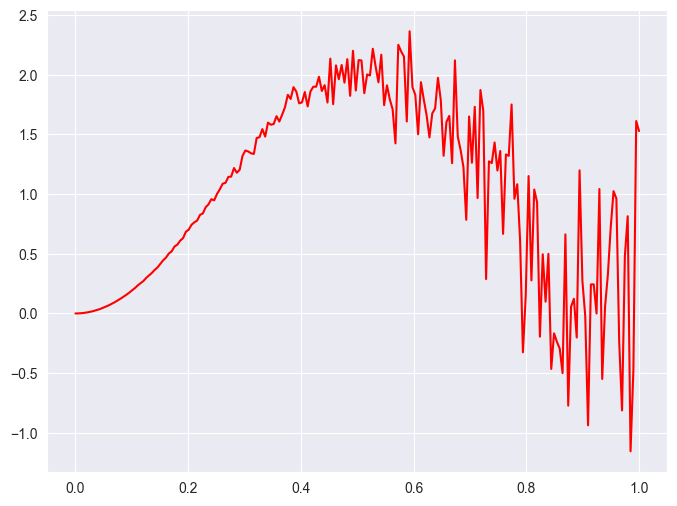

In [12]:
x1 = torch.linspace(0,1.0,200)
y1 = combined_torch(x1)
fig, ax = plt.subplots(1, 1, figsize=(8,6))
sns.lineplot(x=x1, y=y1, ax=ax, color='r')

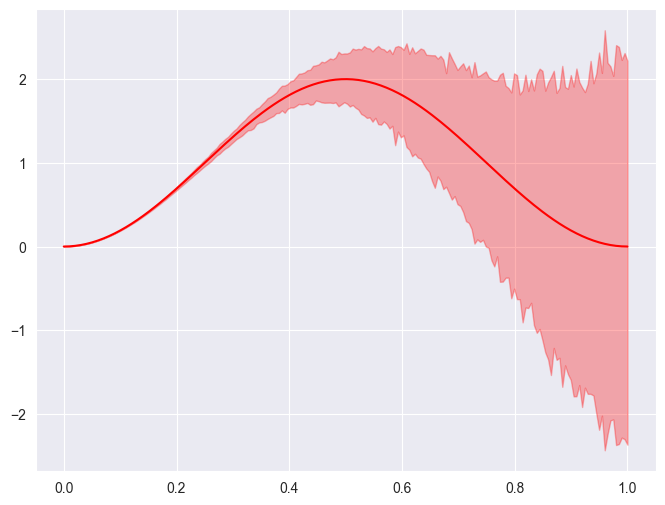

In [13]:
# noise bounds plot
num_reals = 500
num_x = 200
x1 = torch.linspace(0,1.0,num_x)
y_reps = torch.DoubleTensor(num_x, num_reals)
y_deter = example_mean_torch(x1)
for i in range(num_reals):
    y_reps[:,i] = combined_torch(x1)

fig, ax = plt.subplots(1, 1, figsize=(8,6))
sns.lineplot(x=x1, y=y_deter, ax=ax, color='r')
upper_99 = torch.quantile(y_reps, 0.995, dim=1)
lower_01 = torch.quantile(y_reps, 0.005, dim=1)
ax.fill_between(x1, lower_01, upper_99, color='r', alpha=0.3, label=r'99% quantiles')

In [16]:
# wrapper for use in optimization loop
def outcome_objective(x):
    """wrapper for the outcome objective function"""
    # return mme_torch(X).type_as(X)
    return combined_torch(x).type_as(x)

In [17]:
# utility functions

# set up the GP model for use
def initialize_model(train_x, train_obj, state_dict=None):
    """function to initialize the GP model"""
    model_obj = SingleTaskVariationalGP(train_x, train_obj,
                                        outcome_transform=Standardize(m=train_obj.shape[-1]),
                                        input_transform=Normalize(d=train_x.shape[-1]))
    mll = PredictiveLogLikelihood(model_obj.likelihood, model_obj.model, num_data=train_x.shape[-2])
    return mll, model_obj

def initialize_model_stationary(train_x, train_obj, state_dict=None):
    """function to initialize the GP model"""
    model_obj = SingleTaskGP(train_x, train_obj,
                             outcome_transform=Standardize(m=train_obj.shape[-1]),
                             input_transform=Normalize(d=train_x.shape[-1]))
    mll = ExactMarginalLogLikelihood(model_obj.likelihood, model_obj)
    return mll, model_obj

# set up the initial data set
def generate_initial_data(n=10):
    """generate initial set of data to get started with BO loop"""
    train_x = torch.rand(10, 1, device=device, dtype=dtype)
    exact_obj = outcome_objective(train_x)
    # train_obj = exact_obj + NOISE_SE * torch.randn_like(exact_obj)
    train_obj = exact_obj
    best_observed_value = exact_obj.max().item()
    return train_x, train_obj, best_observed_value

from botorch.optim import optimize_acqf
NUM_RESTARTS = 10
RAW_SAMPLES = 512
BATCH_SIZE = 1
bounds = torch.tensor([0.0, 1.0], device=device, dtype=dtype).unsqueeze(-1)
def optimize_acqf_and_get_observation(acq_func):
    """Optimizes the acquisition function, and returns a new candidate and a noisy observation"""
    # optimize
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=bounds,
        q=BATCH_SIZE,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,# initialization heuristic
        options={"batch_limit": 5, "maxiter": 200},
    )
    # observe new values
    new_x = candidates.detach()
    exact_obj = outcome_objective(new_x)
    new_obj = exact_obj
    return new_x, new_obj

def update_random_observation():
    """Simulates a random policy by taking the current list of best values observed
    randomly, drawing a new random point, observing its value, and updating the list
    """
    rand_x = torch.rand(BATCH_SIZE, 1)  # drawing from random uniform
    next_random_best = outcome_objective(rand_x)
    return  rand_x, next_random_best

In [18]:
# SingleTaskGP loop

import time
from botorch.sampling import SobolQMCNormalSampler
from botorch.acquisition.monte_carlo import qNoisyExpectedImprovement
from botorch.acquisition import qLowerBoundMaxValueEntropy
from botorch.acquisition import qMaxValueEntropy

N_TRIALS = 1
N_BATCH = 20 # note +10 for total iteration limit
MC_SAMPLES = 256
BATCH_SIZE = 1

verbose = True
import warnings
warnings.filterwarnings('ignore', category=BadInitialCandidatesWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

# set up arrays to hold arrays of data
# best values
best_observed_all_nei, best_observed_random_all, best_observed_all_gib, best_observed_all_mes = [], [], [], []
# {x, y} values
x_observed_all_random, x_observed_all_nei, x_observed_all_gib, x_observed_all_mes = [], [], [], []
y_observed_all_random, y_observed_all_nei, y_observed_all_gib, y_observed_all_mes = [], [], [], []

# going to average over N_TRIALS
for trial in range(1, N_TRIALS + 1):
    print(f"\nTrial {trial:>2} of {N_TRIALS} ", end="")
    # set up arrays to hold data for this trial
    best_observed_nei, best_observed_random, best_observed_gib, best_observed_mes = [], [], [], []

    # generate initial training data and initial model for this trial
    # nei
    # use same initial training points
    train_x_nei, train_obj_nei, best_observed_value_nei = generate_initial_data(n=10)
    mll_nei, model_nei = initialize_model_stationary(train_x_nei, train_obj_nei)
    # random
    train_x_random, train_obj_random = train_x_nei, train_obj_nei
    # gibbon
    train_x_gib, train_obj_gib, best_observed_value_gib = train_x_nei, train_obj_nei, best_observed_value_nei
    mll_gib, model_gib = initialize_model_stationary(train_x_gib, train_obj_gib)
    # mes
    train_x_mes, train_obj_mes, best_observed_value_mes = train_x_nei, train_obj_nei, best_observed_value_nei
    mll_mes, model_mes = initialize_model_stationary(train_x_mes, train_obj_mes)

    # start collection of results from random initialization
    best_observed_nei.append(best_observed_value_nei)
    best_observed_random.append(best_observed_value_nei)
    best_observed_gib.append(best_observed_value_gib)
    best_observed_mes.append(best_observed_value_mes)

    # for N_BATCH rounds of BO after the initial random batch
    for iteration in range(1, N_BATCH + 1):
        t0 = time.monotonic()
        # fit models
        fit_gpytorch_mll(mll_nei)
        fit_gpytorch_mll(mll_gib)
        fit_gpytorch_mll(mll_mes)

        # set up the sampler to use with the acq funcs
        qmc_sampler = SobolQMCNormalSampler(sample_shape=MC_SAMPLES)

        # set up the acquisition functions
        # NEI
        qNEI = qNoisyExpectedImprovement(
            model=model_nei,
            X_baseline=train_x_nei,
            sampler=qmc_sampler,
        )
        # GIBBON
        candidate_set = torch.rand(10000, bounds.size(1), device=bounds.device, dtype=bounds.dtype)
        qGIB = qLowerBoundMaxValueEntropy(
            model=model_gib,
            candidate_set=candidate_set,
        )
        # MES
        qMES = qMaxValueEntropy(
            model=model_mes,
            candidate_set=candidate_set,
        )

        # optimize the acquisition functions
        # nei
        new_x_nei, new_obj_nei = optimize_acqf_and_get_observation(qNEI)
        # random
        new_x_random, new_obj_random = update_random_observation()
        # gibbon
        new_x_gib, new_obj_gib = optimize_acqf_and_get_observation(qGIB)
        # mes
        new_x_mes, new_obj_mes = optimize_acqf_and_get_observation(qMES)

        # update training points
        # nei
        train_x_nei = torch.cat([train_x_nei, new_x_nei])
        train_obj_nei = torch.cat([train_obj_nei, new_obj_nei])
        # mcs
        train_x_random = torch.cat([train_x_random, new_x_random])
        train_obj_random = torch.cat([train_obj_random, new_obj_random])
        # gibbon
        train_x_gib = torch.cat([train_x_gib, new_x_gib])
        train_obj_gib = torch.cat([train_obj_gib, new_obj_gib])
        # mes
        train_x_mes = torch.cat([train_x_mes, new_x_mes])
        train_obj_mes = torch.cat([train_obj_mes, new_obj_mes])

        # update progress data
        # mcs
        best_value_random = train_obj_random.max()
        best_observed_random.append(best_value_random)
        # nei
        best_value_nei = train_obj_nei.max()
        best_observed_nei.append(best_value_nei)
        # gibbon
        best_value_gib = train_obj_gib.max()
        best_observed_gib.append(best_value_gib)
        # mes
        best_value_mes = train_obj_mes.max()
        best_observed_mes.append(best_value_mes)

        # reinitialize the models so that they're ready to fit on the next iteration
        # state dict passed to speed up fitting
        # nei
        mll_nei, model_nei = initialize_model_stationary(train_x_nei, train_obj_nei)
        # gibbon
        mll_gib, model_gib = initialize_model_stationary(train_x_gib, train_obj_gib)
        # mes
        mll_mes, model_mes = initialize_model_stationary(train_x_mes, train_obj_mes)

        t1 = time.monotonic()

        if verbose:
            print(
                f"\nBatch {iteration:>2}: best_value (random, qNEI) = "
                f"({best_value_random:>4.2f}, {best_value_nei:>4.2f}, {best_value_gib:>4.2f}, {best_value_mes:>4.2f}), "
                f"time = {t1-t0:>4.2f}.", end=""
            )
        else:
            print(".", end="")

    # collect observations from trial
    best_observed_all_nei.append(best_observed_nei)
    best_observed_random_all.append(best_observed_random)
    best_observed_all_gib.append(best_observed_gib)
    best_observed_all_mes.append(best_observed_mes)
    x_observed_all_random.append(train_x_random)
    x_observed_all_nei.append(train_x_nei)
    x_observed_all_nei.append(train_x_gib)
    x_observed_all_nei.append(train_x_mes)
    y_observed_all_random.append(train_obj_random)
    y_observed_all_nei.append(train_obj_nei)
    y_observed_all_nei.append(train_obj_gib)
    y_observed_all_nei.append(train_obj_mes)


Trial  1 of 1 
Batch  1: best_value (random, qNEI) = (2.10, 2.13, 2.10, 2.32), time = 3.08.
Batch  2: best_value (random, qNEI) = (2.10, 2.13, 2.10, 2.32), time = 2.41.
Batch  3: best_value (random, qNEI) = (2.13, 2.13, 2.10, 2.32), time = 2.56.
Batch  4: best_value (random, qNEI) = (2.24, 2.13, 2.10, 2.32), time = 2.75.
Batch  5: best_value (random, qNEI) = (2.24, 2.13, 2.11, 2.32), time = 3.58.
Batch  6: best_value (random, qNEI) = (2.24, 2.13, 2.11, 2.32), time = 3.09.
Batch  7: best_value (random, qNEI) = (2.24, 2.13, 2.11, 2.32), time = 3.49.
Batch  8: best_value (random, qNEI) = (2.24, 2.13, 2.11, 2.32), time = 2.80.
Batch  9: best_value (random, qNEI) = (2.24, 2.13, 2.11, 2.32), time = 3.25.
Batch 10: best_value (random, qNEI) = (2.24, 2.17, 2.11, 2.32), time = 3.89.
Batch 11: best_value (random, qNEI) = (2.24, 2.17, 2.11, 2.32), time = 3.50.
Batch 12: best_value (random, qNEI) = (2.24, 2.17, 2.11, 2.32), time = 3.91.
Batch 13: best_value (random, qNEI) = (2.24, 2.17, 2.11, 2.3

In [19]:
# SingleTaskVariationalGP loop

import time
from botorch.sampling import SobolQMCNormalSampler
from botorch.acquisition.monte_carlo import qNoisyExpectedImprovement
from botorch.acquisition import qLowerBoundMaxValueEntropy
from botorch.acquisition import qMaxValueEntropy

N_TRIALS = 1
N_BATCH = 20 # note +10 for total iteration limit
MC_SAMPLES = 256
BATCH_SIZE = 1

verbose = True
import warnings
warnings.filterwarnings('ignore', category=BadInitialCandidatesWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

# set up arrays to hold arrays of data
# best values
best_observed_all_nei, best_observed_random_all, best_observed_all_gib, best_observed_all_mes = [], [], [], []
# {x, y} values
x_observed_all_random, x_observed_all_nei, x_observed_all_gib, x_observed_all_mes = [], [], [], []
y_observed_all_random, y_observed_all_nei, y_observed_all_gib, y_observed_all_mes = [], [], [], []

# going to average over N_TRIALS
for trial in range(1, N_TRIALS + 1):
    print(f"\nTrial {trial:>2} of {N_TRIALS} ", end="")
    # set up arrays to hold data for this trial
    best_observed_nei, best_observed_random, best_observed_gib, best_observed_mes = [], [], [], []

    # generate initial training data and initial model for this trial
    # nei
    # use same initial training points
    train_x_nei, train_obj_nei, best_observed_value_nei = generate_initial_data(n=10)
    mll_nei, model_nei = initialize_model(train_x_nei, train_obj_nei)
    # random
    train_x_random, train_obj_random = train_x_nei, train_obj_nei
    # gibbon
    train_x_gib, train_obj_gib, best_observed_value_gib = train_x_nei, train_obj_nei, best_observed_value_nei
    mll_gib, model_gib = initialize_model(train_x_gib, train_obj_gib)
    # mes
    train_x_mes, train_obj_mes, best_observed_value_mes = train_x_nei, train_obj_nei, best_observed_value_nei
    mll_mes, model_mes = initialize_model(train_x_mes, train_obj_mes)

    # start collection of results from random initialization
    best_observed_nei.append(best_observed_value_nei)
    best_observed_random.append(best_observed_value_nei)
    best_observed_gib.append(best_observed_value_gib)
    best_observed_mes.append(best_observed_value_mes)

    # for N_BATCH rounds of BO after the initial random batch
    for iteration in range(1, N_BATCH + 1):
        t0 = time.monotonic()
        # fit models
        fit_gpytorch_mll(mll_nei)
        fit_gpytorch_mll(mll_gib)
        fit_gpytorch_mll(mll_mes)

        # set up the sampler to use with the acq funcs
        qmc_sampler = SobolQMCNormalSampler(sample_shape=MC_SAMPLES)

        # set up the acquisition functions
        # NEI
        qNEI = qNoisyExpectedImprovement(
            model=model_nei,
            X_baseline=train_x_nei,
            sampler=qmc_sampler,
        )
        # GIBBON
        candidate_set = torch.rand(10000, bounds.size(1), device=bounds.device, dtype=bounds.dtype)
        qGIB = qLowerBoundMaxValueEntropy(
            model=model_gib,
            candidate_set=candidate_set,
        )
        # MES
        qMES = qMaxValueEntropy(
            model=model_mes,
            candidate_set=candidate_set,
        )

        # optimize the acquisition functions
        # nei
        new_x_nei, new_obj_nei = optimize_acqf_and_get_observation(qNEI)
        # random
        new_x_random, new_obj_random = update_random_observation()
        # gibbon
        new_x_gib, new_obj_gib = optimize_acqf_and_get_observation(qGIB)
        # mes
        new_x_mes, new_obj_mes = optimize_acqf_and_get_observation(qMES)

        # update training points
        # nei
        train_x_nei = torch.cat([train_x_nei, new_x_nei])
        train_obj_nei = torch.cat([train_obj_nei, new_obj_nei])
        # mcs
        train_x_random = torch.cat([train_x_random, new_x_random])
        train_obj_random = torch.cat([train_obj_random, new_obj_random])
        # gibbon
        train_x_gib = torch.cat([train_x_gib, new_x_gib])
        train_obj_gib = torch.cat([train_obj_gib, new_obj_gib])
        # mes
        train_x_mes = torch.cat([train_x_mes, new_x_mes])
        train_obj_mes = torch.cat([train_obj_mes, new_obj_mes])

        # update progress data
        # mcs
        best_value_random = train_obj_random.max()
        best_observed_random.append(best_value_random)
        # nei
        best_value_nei = train_obj_nei.max()
        best_observed_nei.append(best_value_nei)
        # gibbon
        best_value_gib = train_obj_gib.max()
        best_observed_gib.append(best_value_gib)
        # mes
        best_value_mes = train_obj_mes.max()
        best_observed_mes.append(best_value_mes)

        # reinitialize the models so that they're ready to fit on the next iteration
        # state dict passed to speed up fitting
        # nei
        mll_nei, model_nei = initialize_model(train_x_nei, train_obj_nei)
        # gibbon
        mll_gib, model_gib = initialize_model(train_x_gib, train_obj_gib)
        # mes
        mll_mes, model_mes = initialize_model(train_x_mes, train_obj_mes)

        t1 = time.monotonic()

        if verbose:
            print(
                f"\nBatch {iteration:>2}: best_value (random, qNEI) = "
                f"({best_value_random:>4.2f}, {best_value_nei:>4.2f}, {best_value_gib:>4.2f}, {best_value_mes:>4.2f}), "
                f"time = {t1-t0:>4.2f}.", end=""
            )
        else:
            print(".", end="")

    # collect observations from trial
    best_observed_all_nei.append(best_observed_nei)
    best_observed_random_all.append(best_observed_random)
    best_observed_all_gib.append(best_observed_gib)
    best_observed_all_mes.append(best_observed_mes)
    x_observed_all_random.append(train_x_random)
    x_observed_all_nei.append(train_x_nei)
    x_observed_all_nei.append(train_x_gib)
    x_observed_all_nei.append(train_x_mes)
    y_observed_all_random.append(train_obj_random)
    y_observed_all_nei.append(train_obj_nei)
    y_observed_all_nei.append(train_obj_gib)
    y_observed_all_nei.append(train_obj_mes)


Trial  1 of 1 

AttributeError: 'SingleTaskVariationalGP' object has no attribute 'batch_shape'